# Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

# EDA

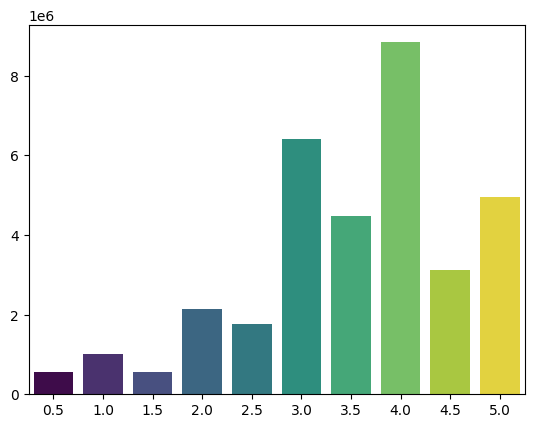

In [3]:
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [4]:
ratings = ratings.drop(columns="timestamp")
ratings.head()

,user_id,movie_id,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [5]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


# Preprocessing

## Filtering

In [6]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print(f"Average ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"Max ratings: {ratings_per_user.max()}")
print()
mean_user_rating = ratings_per_user.mean()

# Filtering out users with less than the average number of ratings
user_rating_counts = ratings["user_id"].value_counts()
average_users = user_rating_counts[user_rating_counts >= mean_user_rating].index
filtered_ratings = ratings[ratings["user_id"].isin(average_users)]

# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.2%} of the original dataset.")

Average ratings per user: 102.22
Median ratings per user: 31.00
Min ratings: 1
Max ratings: 33332

There are now 79469 users in the dataset. 24.01% of the original dataset.


In [7]:
# Finding stats on movie ratings
ratings_per_movie = ratings.groupby("movie_id").size()
print(f"Average ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"Max ratings: {ratings_per_movie.max()}")
print()

# Filtering out movies with less than the average number of ratings
movie_rating_counts = ratings["movie_id"].value_counts()
average_movies = movie_rating_counts[movie_rating_counts >= 25].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(average_movies)]

# Reviewing the filtered dataset
n_movies_filtered = filtered_ratings["movie_id"].nunique()
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.2%} of the original dataset.")

Average ratings per movie: 406.45
Median ratings per movie: 5.00
Min ratings: 1
Max ratings: 122296

There are now 21297 movies in the dataset. 25.59% of the original dataset.


In [8]:
ratings = filtered_ratings

## Standardising user ratings

In [ ]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [ ]:
# Creates a new column with the average rating for each user
ratings["std_rating"] = ratings.groupby("user_id")["rating"].transform(lambda x: (x - x.mean()) / x.std())

In [10]:
ratings.head(2)

,user_id,movie_id,rating,std_rating
304,7,1,4.0,0.907027
305,7,3,3.0,-0.465995


## Matrix creation

In [12]:
# Create sparse matrix
users = ratings["user_id"].values
movies = ratings["movie_id"].values
ratings = ratings["rating"].values

# Create mappings for row/column indices
user_mapper = {user: i for i, user in enumerate(np.unique(users))}
movie_mapper = {movie: i for i, movie in enumerate(np.unique(movies))}

# Map to matrix indices
user_indices = np.array([user_mapper[user] for user in users])
movie_indices = np.array([movie_mapper[movie] for movie in movies])

# Create the sparse matrix
user_movie_matrix = csr_matrix((ratings, (user_indices, movie_indices)))

In [ ]:
user_movie_matrix.shape

(79469, 21297)